In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

### Exploring Data

In [3]:
os.listdir('/kaggle/input/butterfly-image-classification')

['Training_set.csv', 'Testing_set.csv', 'test', 'train']

In [4]:
training_data=pd.read_csv("/kaggle/input/butterfly-image-classification/Training_set.csv")
training_data.head()

,filename,label
0,Image_1.jpg,SOUTHERN DOGFACE
1,Image_2.jpg,ADONIS
2,Image_3.jpg,BROWN SIPROETA
3,Image_4.jpg,MONARCH
4,Image_5.jpg,GREEN CELLED CATTLEHEART


In [5]:
testing_data=pd.read_csv("/kaggle/input/butterfly-image-classification/Testing_set.csv")
testing_data.head()

,filename
0,Image_1.jpg
1,Image_2.jpg
2,Image_3.jpg
3,Image_4.jpg
4,Image_5.jpg


In [6]:
training_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6499 entries, 0 to 6498
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  6499 non-null   object
 1   label     6499 non-null   object
dtypes: object(2)
memory usage: 101.7+ KB


In [7]:
testing_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2786 entries, 0 to 2785
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  2786 non-null   object
dtypes: object(1)
memory usage: 21.9+ KB


In [8]:
classes=np.unique(training_data['label'])
len(classes),classes

(75,
 array(['ADONIS', 'AFRICAN GIANT SWALLOWTAIL', 'AMERICAN SNOOT', 'AN 88',
        'APPOLLO', 'ATALA', 'BANDED ORANGE HELICONIAN', 'BANDED PEACOCK',
        'BECKERS WHITE', 'BLACK HAIRSTREAK', 'BLUE MORPHO',
        'BLUE SPOTTED CROW', 'BROWN SIPROETA', 'CABBAGE WHITE',
        'CAIRNS BIRDWING', 'CHECQUERED SKIPPER', 'CHESTNUT', 'CLEOPATRA',
        'CLODIUS PARNASSIAN', 'CLOUDED SULPHUR', 'COMMON BANDED AWL',
        'COMMON WOOD-NYMPH', 'COPPER TAIL', 'CRECENT', 'CRIMSON PATCH',
        'DANAID EGGFLY', 'EASTERN COMA', 'EASTERN DAPPLE WHITE',
        'EASTERN PINE ELFIN', 'ELBOWED PIERROT', 'GOLD BANDED',
        'GREAT EGGFLY', 'GREAT JAY', 'GREEN CELLED CATTLEHEART',
        'GREY HAIRSTREAK', 'INDRA SWALLOW', 'IPHICLUS SISTER', 'JULIA',
        'LARGE MARBLE', 'MALACHITE', 'MANGROVE SKIPPER', 'MESTRA',
        'METALMARK', 'MILBERTS TORTOISESHELL', 'MONARCH', 'MOURNING CLOAK',
        'ORANGE OAKLEAF', 'ORANGE TIP', 'ORCHARD SWALLOW', 'PAINTED LADY',
        'PAPER KITE', '

In [9]:
bool_labels=[label==classes for label in training_data['label']]
len(bool_labels),bool_labels[0]

(6499,
 array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False,  True, False, False, False, False, False,
        False, False, False]))

### Splitting into Training and Test Datasets

In [10]:
train_filenames=['/kaggle/input/butterfly-image-classification/train/'+filename for filename in training_data['filename']]
len(train_filenames),train_filenames[0]

(6499, '/kaggle/input/butterfly-image-classification/train/Image_1.jpg')

In [11]:
test_filenames=['/kaggle/input/butterfly-image-classification/test/'+filename for filename in testing_data['filename']]
len(test_filenames),test_filenames[0]

(2786, '/kaggle/input/butterfly-image-classification/test/Image_1.jpg')

In [12]:
x_train=train_filenames
y_train=bool_labels
x_test=test_filenames
len(x_train),len(y_train),len(x_test)

(6499, 6499, 2786)

### Preprocessing Data

In [13]:
import tensorflow as tf

def process_image(filename,label=None):
    #Read the image
    image=tf.io.read_file(filename)
    #Decode image into a tensor
    image=tf.image.decode_jpeg(image,channels=3)
    #Resize the image
    image=tf.image.resize(image,[224,224])
    #Normalise the pixels to the range of 0-1
    image=image/255
    return image,label

2024-06-16 14:42:15.810816: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-16 14:42:15.810931: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-16 14:42:15.985932: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [14]:
def get_batches(x,y=None,test_data=False):
    if test_data:
        print("Creating test data batches...")
        test_data=tf.data.Dataset.from_tensor_slices((tf.constant(x)))
        data_batch=test_data.map(process_image).batch(256)
    else:
        print("Creating training batches...")
        train_data=tf.data.Dataset.from_tensor_slices((tf.constant(x),tf.constant(y)))
        data_batch=train_data.map(process_image).batch(256)
    return data_batch

In [15]:
train_data=get_batches(x_train,y_train)
test_data=get_batches(x_test,test_data=True)

Creating training batches...
Creating test data batches...


In [16]:
train_images,train_labels=next(train_data.as_numpy_iterator())

### Creating Model

In [17]:
from tensorflow import keras
model=keras.models.Sequential([
    keras.layers.Input(shape=(224, 224, 3)),
    keras.layers.Conv2D(filters=32,kernel_size=(3,3),activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2,2)),
    keras.layers.Conv2D(filters=32,kernel_size=(3,3),activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2,2)),
    keras.layers.Conv2D(filters=32,kernel_size=(3,3),activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(units=128,activation='relu'),
    keras.layers.Dense(units=75,activation='softmax')
])


In [18]:
model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    metrics=['accuracy']
)

In [19]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 21632)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     2,769,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 75)             │         9,675 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,798,091 (10.67 MB)

 Trainable params: 2,798,091 (10.67 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
class MyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self,epoch,logs={}):
        if logs.get('accuracy') > 0.95:
            print("Model will stop training now as it's accuracy has reached 95%")
            self.model.stop_training=True
callbacks=MyCallback()

### Training Model

In [21]:
history=model.fit(
    x=train_data,
    batch_size=32,
    epochs=50,
    callbacks=[callbacks]
)

Epoch 1/50


I0000 00:00:1718548982.361546     104 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1718548982.379178     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


26/26 ━━━━━━━━━━━━━━━━━━━━ 62s 1s/step - accuracy: 0.0189 - loss: 7.8633 
Epoch 2/50


W0000 00:00:1718549011.090871     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 190ms/step - accuracy: 0.0961 - loss: 3.9480
Epoch 3/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 191ms/step - accuracy: 0.2349 - loss: 3.2628
Epoch 4/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 191ms/step - accuracy: 0.3259 - loss: 2.7468
Epoch 5/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 192ms/step - accuracy: 0.4326 - loss: 2.2735
Epoch 6/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 192ms/step - accuracy: 0.5405 - loss: 1.7009
Epoch 7/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 192ms/step - accuracy: 0.6479 - loss: 1.2724
Epoch 8/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 191ms/step - accuracy: 0.6768 - loss: 1.1534
Epoch 9/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 191ms/step - accuracy: 0.7162 - loss: 1.0229
Epoch 10/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 190ms/step - accuracy: 0.7164 - loss: 1.0184
Epoch 11/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 190ms/step - accuracy: 0.7044 - loss: 1.0732
Epoch 12/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 189ms/step - accuracy: 0.7135 - loss: 1.0256
Epoch 13/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 189ms/step - accurac

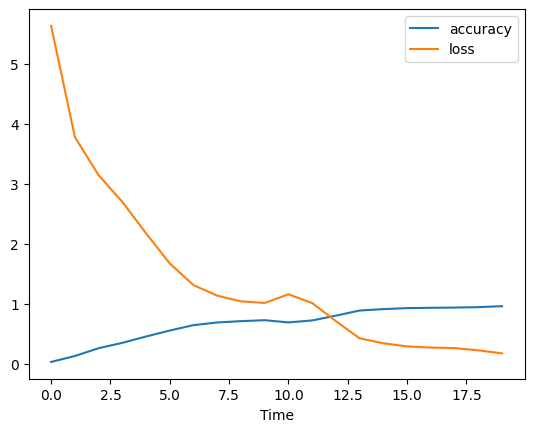

In [22]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])
plt.xlabel('Time')
plt.legend(['accuracy', 'loss'])
plt.show()

### Making predictions on test dataset

In [23]:
test_preds=model.predict(test_data,verbose=1)

 1/11 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step

W0000 00:00:1718549122.279777     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


11/11 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step 


W0000 00:00:1718549141.939041     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


In [24]:
test_preds.shape

(2786, 75)

In [25]:
test_pred_labels=[classes[np.argmax(test_preds[i])] for i in range(len(test_preds))]
test_pred_labels[:10]

['CRECENT',
 'RED ADMIRAL',
 'COMMON WOOD-NYMPH',
 'ULYSES',
 'MILBERTS TORTOISESHELL',
 'SOOTYWING',
 'MILBERTS TORTOISESHELL',
 'RED CRACKER',
 'RED SPOTTED PURPLE',
 'CAIRNS BIRDWING']

In [26]:
test_file_paths=['/kaggle/input/butterfly-image-classification/test/'+filename for filename in testing_data['filename']]
test_file_paths[0]

'/kaggle/input/butterfly-image-classification/test/Image_1.jpg'

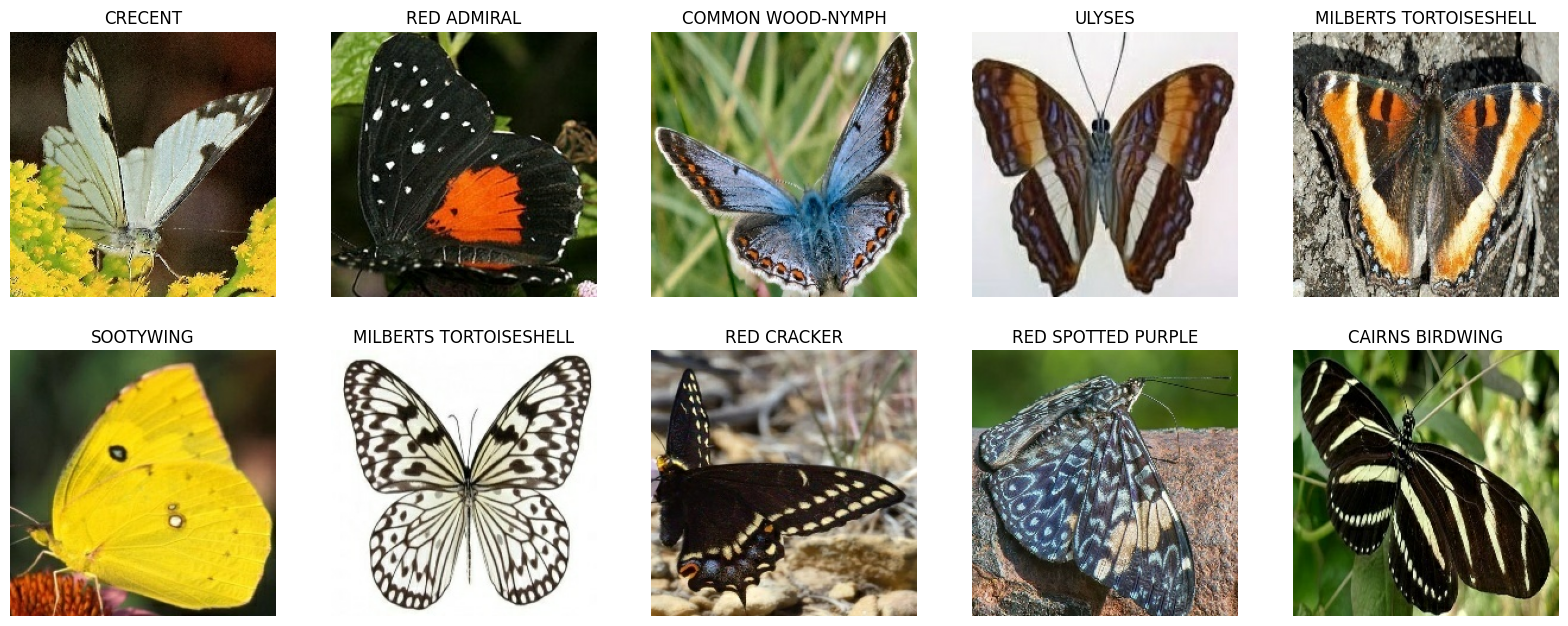

In [30]:
plt.figure(figsize=(20,20))
for i in range(10):
    plt.subplot(5,5,i+1)
    img,_=process_image(test_file_paths[i])  
    plt.imshow(img.numpy())  
    plt.title(test_pred_labels[i])
    plt.axis('off')
plt.show()